# A2C Model for RLPaint

## Imports

In [12]:
# Full imports
import gym
import cv2

# Partial imports 
from tqdm.notebook import tqdm, trange
from telesketch.envs.discrete_telesketch import DiscreteTelesketchEnv
from typing import Any, List, Sequence, Tuple
from numpy import linalg as LA

# Aliased imports
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Image
from skimage.metrics import normalized_root_mse
from skimage.feature import match_template


## Bootstrap

In [13]:
# Remember to export to export "LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/"" if using linux
# Drop numa errors in term: "for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done"

# Check if we have GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Constants

In [14]:
# Define min epsilon so we don't run into inf
# on divisions
EPS = np.finfo(np.float32).eps.item()

# Use Huber loss for crisitic as it's less sensitive to outliers than MSE
HUBER_LOSS = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

# Define patch size
# Must be odd
PATCH_SIZE = (31, 31)

## Environment Interaction

In [15]:
def compute_returns(rewards: tf.Tensor, gamma: float, std: bool = True) -> tf.Tensor:
    # Prepare aux vars
    rewards = tf.cast(rewards, dtype=tf.float32)
    t = tf.range(tf.size(rewards), dtype=tf.float32)

    # Compute factors
    delta = rewards * gamma ** t
    g = tf.cumsum(delta[::-1])[::-1] / gamma ** t

    # Std if needed
    if std:
        g = (g - tf.reduce_mean(g)) / (tf.math.reduce_std(g) + EPS)
    
    # Return expected returns
    return g

In [16]:
def compute_loss(log_probs: tf.Tensor, values: tf.Tensor, returns: tf.Tensor, critic_weight: float = 0.5) -> tf.Tensor:
    adv = returns - values

    # Actor loss
    actor_loss = -tf.math.reduce_sum(log_probs * adv)

    # Critic loss
    # Use hubber loss because it's more stable to outliers than delta^2
    critic_loss = HUBER_LOSS(values, returns)

    return actor_loss + critic_loss * critic_weight

In [17]:
class Trainer:
    def __init__(self, env: gym.Env, model: tf.keras.Model, optimizer: tf.keras.optimizers.Optimizer, max_steps=300) -> None:
        # Make internal copy of params
        self._env = env
        self._model = model
        self._optimizer = optimizer
        self._max_steps = max_steps

    # Define aux methods for vectorization
    def _aux_np_step(self, action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        state, reward, done, _ = self._env.step(int(action))

        return (
            state["loc"].astype(np.float32),
            state["ref"].astype(np.float32),
            state["cnv"].astype(np.float32),
            state["ref_patch"].astype(np.float32),
            state["cnv_patch"].astype(np.float32),
            np.array(reward, np.float32),
            np.array(done, np.int32)
        )

    def _tf_step(self, action: tf.Tensor) -> List[tf.Tensor]:
        return tf.numpy_function(self._aux_np_step, [action], [tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.int32])
    

    def run_episode(self, init_state_loc, init_state_ref, init_state_cnv, init_state_ref_patch, init_state_cnv_patch):
        log_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)
        values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)
        rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)
        
        # Reset and init states
        state_loc = init_state_loc
        state_ref = init_state_ref
        state_cnv = init_state_cnv
        state_ref_patch = init_state_ref_patch
        state_cnv_patch = init_state_cnv_patch

        # Save shapes
        global_shape = state_ref.shape
        local_shape = state_ref_patch.shape


        # Init agent and get state
        for i in tf.range(self._max_steps):
            # Predict action
            action, log_prob, value = self._model(state_loc, state_ref, state_cnv, state_ref_patch, state_cnv_patch)

            # Perform action
            state_loc, state_ref, state_cnv, state_ref_patch, state_cnv_patch, reward, done = self._tf_step(action[0])

            # Store result in buffer
            log_probs = log_probs.write(i, tf.squeeze(log_prob))
            values = values.write(i, tf.squeeze(value))
            rewards = rewards.write(i, tf.squeeze(reward))

            state_loc.set_shape(global_shape)
            state_ref.set_shape(global_shape)
            state_cnv.set_shape(global_shape)
            state_ref_patch.set_shape(local_shape)
            state_cnv_patch.set_shape(local_shape)

            # Bail-out if episode is finished
            if tf.cast(done, tf.bool): break
        
        # Stack to get proper tensors
        log_probs = log_probs.stack()
        values = values.stack()
        rewards = rewards.stack() 

        return log_probs, values, rewards

    @tf.function
    def train(self, init_state_loc, init_state_ref, init_state_cnv, init_state_ref_patch, init_state_cnv_patch, gamma: float, max_steps: int) -> tf.Tensor:
        with tf.GradientTape() as tape:
            # Collect samples
            log_probs, values, rewards = self.run_episode(
                init_state_loc,
                init_state_ref, 
                init_state_cnv, 
                init_state_ref_patch, 
                init_state_ref_patch
            )

            returns = compute_returns(rewards, gamma) 

            # Keep in mind to expand to columns, 
            # huber loss reduces differently based on this fact
            log_probs, values, returns = [
                tf.expand_dims(x, 1) for x in [log_probs, values, returns]
            ] 

            # Compute loss
            loss = compute_loss(log_probs, values, returns)

        # Apply gradients
        grads = tape.gradient(loss, self._model.trainable_variables)
        self._optimizer.apply_gradients(zip(grads, self._model.trainable_variables))

        # Return total reward
        return tf.math.reduce_sum(rewards), rewards

In [18]:
class ActorCritic(tf.keras.Model):
    def __init__(self, env: gym.Env) -> None:
        # Call super to properly init
        super().__init__()

        global_input = env.observation_space["cnv"].shape + (1,)
        local_input = env.observation_space["cnv_patch"].shape + (1,)

        dmap_block = keras.Sequential([
            keras.Input(shape=global_input),
            keras.layers.Conv2D(32, (8, 8), (4, 4)),
            keras.layers.LeakyReLU(alpha=0.01),
            keras.layers.Conv2D(64, (4, 4), (2, 2)),
            keras.layers.LeakyReLU(alpha=0.01),
            keras.layers.Conv2D(64, (3, 3)),
            keras.layers.Flatten()
        ])

        global_ref_block = keras.Sequential([
            keras.Input(shape=global_input),
            keras.layers.Conv2D(32, (8, 8), (4, 4)),
            keras.layers.LeakyReLU(alpha=0.01),
            keras.layers.Conv2D(64, (4, 4), (2, 2)),
            keras.layers.LeakyReLU(alpha=0.01),
            keras.layers.Conv2D(64, (3, 3)),
            keras.layers.Flatten()
        ])

        global_cnv_block = keras.Sequential([
            keras.Input(shape=global_input),
            keras.layers.Conv2D(32, (8, 8), (4, 4)),
            keras.layers.LeakyReLU(alpha=0.01),
            keras.layers.Conv2D(64, (4, 4), (2, 2)),
            keras.layers.LeakyReLU(alpha=0.01),
            keras.layers.Conv2D(64, (3, 3)),
            keras.layers.Flatten()
        ])

        local_ref_input = keras.Sequential([
            keras.Input(shape=local_input),
            keras.layers.Conv2D(64, (8, 8)),
            keras.layers.LeakyReLU(alpha=0.01),
            keras.layers.Flatten()
        ])

        local_cnv_input = keras.Sequential([
            keras.Input(shape=local_input),
            keras.layers.Conv2D(64, (8, 8)),
            keras.layers.LeakyReLU(alpha=0.01),
            keras.layers.Flatten()
        ])

        block_concat = keras.layers.Concatenate()([
            dmap_block.output,
            global_ref_block.output,
            global_cnv_block.output,
            local_ref_input.output,
            local_cnv_input.output
        ])

        actor_out = keras.layers.Dense(8)(block_concat)
        critic_out = keras.layers.Dense(1)(block_concat)

        self.model = keras.Model(
            [
                dmap_block.input,
                global_ref_block.input, 
                global_cnv_block.input, 
                local_ref_input.input, 
                local_cnv_input.input
            ], 
            [
                actor_out, 
                critic_out
            ]
        )
        

    def call(self, dmap: tf.Tensor, gref: tf.Tensor, gcnv: tf.Tensor, lref: tf.Tensor, lcnv: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        # Expand inputs
        inputs = [tf.expand_dims(x, 0) for x in [dmap, gref, gcnv, lref, lcnv]]

        # Apply model layers
        actor_out, value = self.model(inputs)

        # Compute distribution of actions for actor and pick one and corresponding log_prob
        action_dist = tfp.distributions.Categorical(logits=actor_out, dtype=tf.float32)
        action = action_dist.sample()

        return action, action_dist.log_prob(action), value
        

In [19]:
class Player:
    def __init__(self, model, env):
        self._model = model
        self._env = env
    
    def reset(self):
        self._state = self._env.reset()[0].values()
    
    def step(self):
        # Pick an action
        action = int(self._model(*self._state)[0].numpy()[0])
        
        # Perform action
        step_output = self._env.step(action)
        self._state = step_output[0].values()

        return step_output[1], step_output[3]
    
    def render(self):
        self._env.render()

In [20]:
# Ref canvas
IMG_SIZE = 64
PATCH_SIZE = 8
ref_canvas = np.full((IMG_SIZE, IMG_SIZE, 3), 255, dtype=np.uint8)
ref_canvas = cv2.line(ref_canvas, (0, 0), (32, 32), (0, 0, 0), 2)
ref_canvas = cv2.line(ref_canvas, (32, 32), (64, 32), (0, 0, 0), 2)


env = DiscreteTelesketchEnv(ref_canvas, match_template, 5, 2, patch_size=(PATCH_SIZE, PATCH_SIZE), render_mode="image", threshold=0.8)

env.reset();


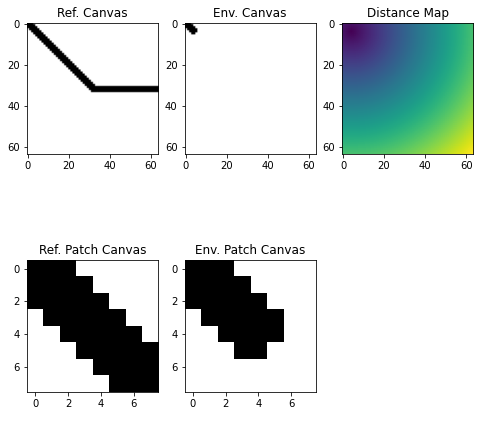

In [21]:
env.step(1)
env.render()

In [23]:
LR = 0.001
GAMMA = 0.99
N_EPISODES = 1000
MAX_STEPS = 500
CRITIC_WEIGHT = 1

# Define basic vars

model = ActorCritic(env)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

# Define trainer
trainer = Trainer(env, model, optimizer, MAX_STEPS)

rewards = []

# Start training
try:
    for e in (tbar := trange(N_EPISODES)):
        # Reset environment
        state = trainer._env.reset()[0]

        init_state_loc = tf.constant(state["loc"], dtype=tf.float32)
        init_state_ref = tf.constant(state["ref"], dtype=tf.float32)
        init_state_cnv = tf.constant(state["cnv"], dtype=tf.float32)
        init_state_ref_patch = tf.constant(state["ref_patch"], dtype=tf.float32)
        init_state_ref_patch = tf.constant(state["cnv_patch"], dtype=tf.float32)

        # Run training
        reward_e, rts = trainer.train(init_state_loc, init_state_ref, init_state_cnv, init_state_ref_patch, init_state_ref_patch, GAMMA, MAX_STEPS)

        # Save rewards
        rewards.append(float(reward_e))

        # Update progressbar
        tbar.set_postfix(reward=float(reward_e))

except KeyboardInterrupt:
    print("Training stopped...")

  0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-21 18:26:10.298634: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1060 3GB" frequency: 1759 num_cores: 9 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 1688928256 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [11]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [12]:
# Make pd
data_pd = pd.DataFrame({"r":rewards})

# Compute confidence intervals 
data_pd = (data_pd
    .assign(roll_avg_r=lambda x: x.r.rolling(50).mean())
    .assign(roll_std_r=lambda x: x.r.rolling(50).std())
    .assign(upper_r=lambda x: x.roll_avg_r + 1.96 * x.roll_std_r)
    .assign(lower_r=lambda x: x.roll_avg_r - 1.96 * x.roll_std_r)
)
#data_pd.to_csv("data/vanilla.csv")


# Plot
fig = go.Figure()

# Add traces
fig.add_trace(
    go.Scatter(x=data_pd.index, y=data_pd.roll_avg_r, mode="lines", name="Reward")
)

fig.add_trace(
    go.Scatter(x=data_pd.index, 
               y=data_pd.upper_r,
               marker=dict(color="#444"),
               line=dict(width=0),
               mode="lines", 
               name="Roll. Avg. Reward",
               showlegend=False)
)

fig.add_trace(
    go.Scatter(x=data_pd.index, 
               y=data_pd.lower_r,
               fillcolor='rgba(68, 68, 68, 0.3)',
               marker=dict(color="#444"),
               line=dict(width=0),
               fill='tonexty',
               mode="lines", 
               name="Roll. Avg. Reward",
               showlegend=False)
)


# Update fig optiosn
fig.update_layout(
    template="plotly_white",
    margin=dict(l=20, r=20, t=20, b=20),
    xaxis_title="Episode",
    yaxis_title="Reward"
)

fig.show()

In [12]:
player = Player(trainer._model, trainer._env)
player.reset()

(-1, {'sim': 0.36214900538538386})


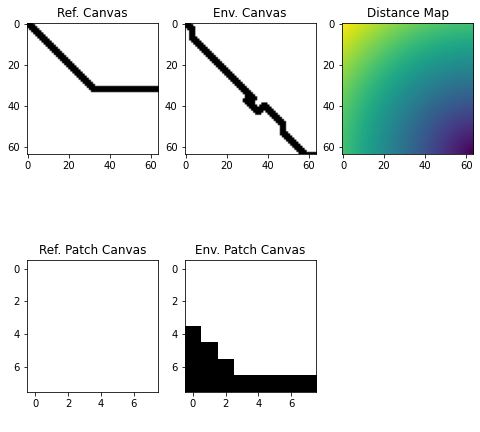

In [54]:
print(player.step())
player.render()



In [55]:
LA.norm(np.array([0, 0]) - np.array([3, 3]))

4.242640687119285